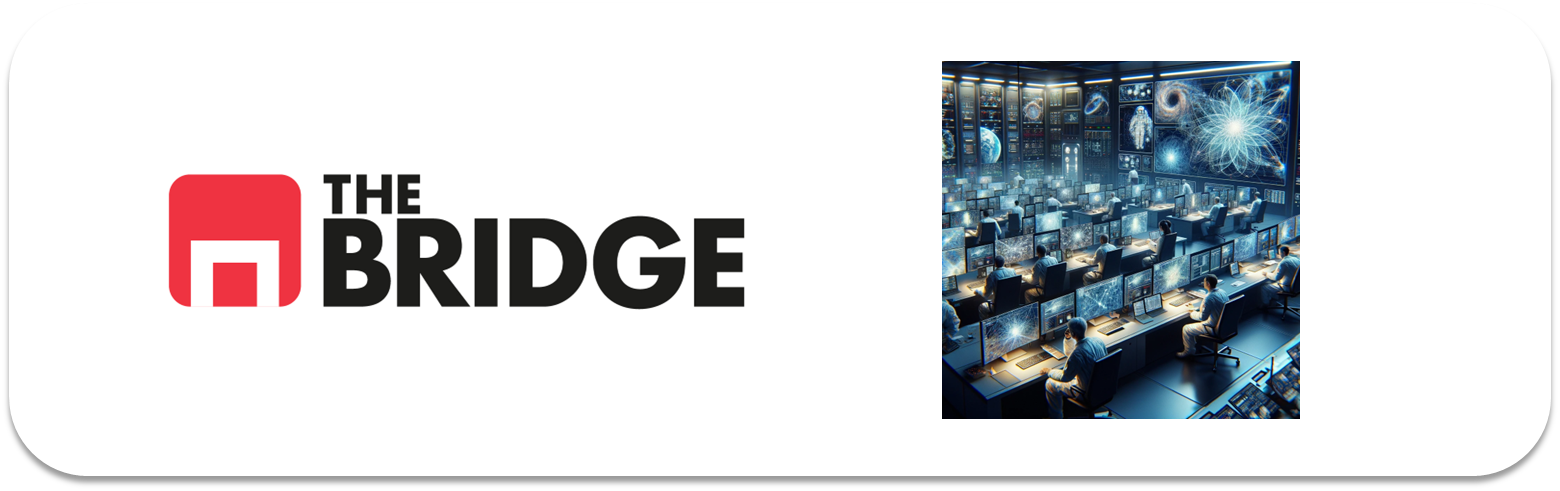

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.

In [3]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [4]:
PATH = r"C:\Users\Nur\Documents\GitHub\online_ds_thebridge_Nur\ejercicios\05_Deep_Learning\Sprint_19\Unidad_01\Ejercicios_Workout\data"

import pickle

# Abre el archivo en modo lectura binaria
with open(PATH+'/train.pkl', 'rb') as f:
    # Carga el objeto desde el archivo
    objeto = pickle.load(f)

X_train, y_train = objeto
X_train.shape, y_train.shape

((14031, 32, 32, 3), (14031,))

In [5]:
PATH = r"C:\Users\Nur\Documents\GitHub\online_ds_thebridge_Nur\ejercicios\05_Deep_Learning\Sprint_19\Unidad_01\Ejercicios_Workout\data"

import pickle

# Abre el archivo en modo lectura binaria
with open(PATH+'/test.pkl', 'rb') as f:
    # Carga el objeto desde el archivo
    objeto = pickle.load(f)

X_test, y_test = objeto
X_test.shape, y_test.shape

((3000, 32, 32, 3), (3000,))

In [6]:
X_train, y_train = shuffle(X_train, y_train)

In [7]:
X_train = X_train / 255
X_test = X_test / 255

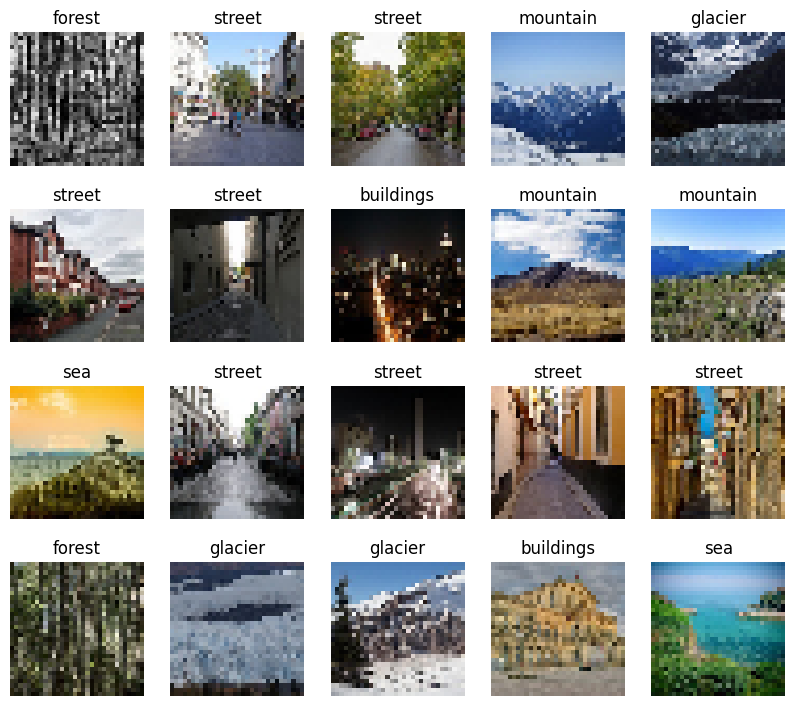

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
mapping = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
inverse_mapping = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

y_train_num = np.array(pd.Series(y_train).map(mapping))
y_test_num = np.array(pd.Series(y_test).map(mapping))

In [10]:
pd.Series(y_train).value_counts(True)

mountain     0.179032
glacier      0.171335
street       0.169624
sea          0.161998
forest       0.161856
buildings    0.156154
Name: proportion, dtype: float64

### Transfer Learning

In [11]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(32,32,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(3072, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(len(pd.Series(y_train).unique()), activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 6,211,654 (23.70 MB)

 Trainable params: 3,953,670 (15.08 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [13]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {instancias_train/(32*i)}")

Batch_size: 32, num_steps_per_epoch: 438.46875
Batch_size: 64, num_steps_per_epoch: 219.234375
Batch_size: 96, num_steps_per_epoch: 146.15625
Batch_size: 128, num_steps_per_epoch: 109.6171875


In [14]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 96,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - acc: 0.4239 - loss: 1.4460 - val_acc: 0.5094 - val_loss: 1.2513
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - acc: 0.5305 - loss: 1.1977 - val_acc: 0.5294 - val_loss: 1.2129
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - acc: 0.5507 - loss: 1.1499 - val_acc: 0.5258 - val_loss: 1.2070
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - acc: 0.5547 - loss: 1.1169 - val_acc: 0.5187 - val_loss: 1.2150
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - acc: 0.5711 - loss: 1.0853 - val_acc: 0.5411 - val_loss: 1.1868
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - acc: 0.5787 - loss: 1.0612 - val_acc: 0.5365 - val_loss: 1.1934
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - acc: 0.5840 - loss: 1.0466 - val_acc: 0.5454 - val_loss: 1.1846
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - acc: 0.6003 - loss: 1.0247 - val_acc: 0.5493 - val_loss: 1.1853
Epoch 9/100
117/117 ━━━━━━━━━━━━

In [15]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.5785 - loss: 1.1276


[1.1943233013153076, 0.5293333530426025]

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
              precision    recall  f1-score   support

   buildings       0.52      0.55      0.53       437
      forest       0.77      0.83      0.80       474
     glacier       0.42      0.45      0.43       553
    mountain       0.48      0.46      0.47       525
         sea       0.50      0.51      0.51       510
      street       0.50      0.41      0.45       501

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.53      0.53      3000



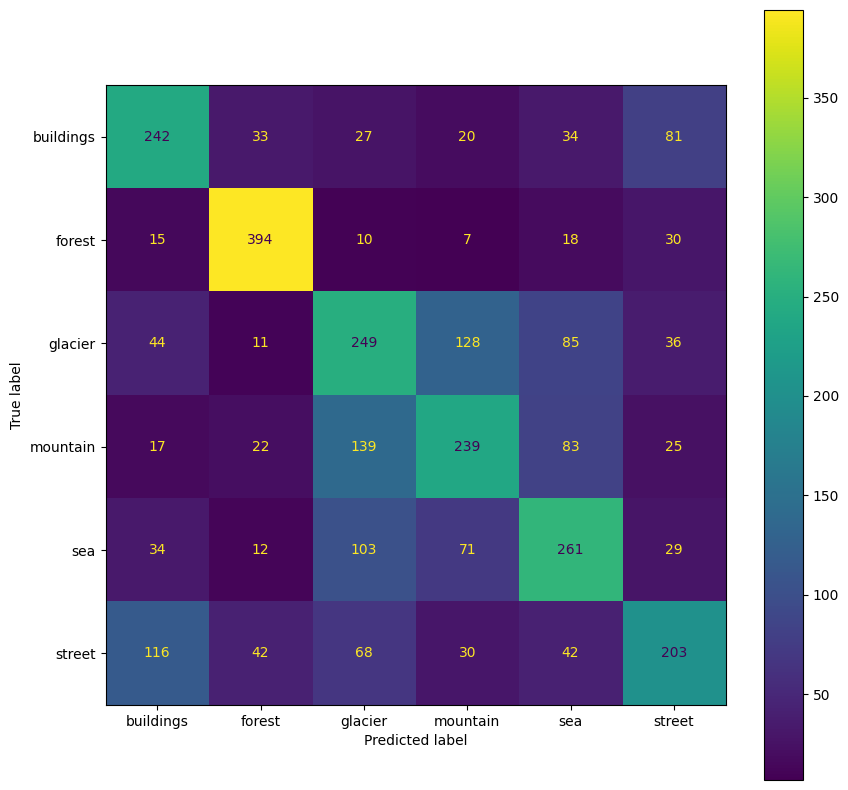

In [17]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

### Fine Tuning

In [32]:
import keras

In [33]:
base_model = MobileNetV2(include_top=False, weights=None, input_shape=(32,32,3))

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(512, activation="relu")(x)
    #x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(len(pd.Series(y_train).unique()), activation="softmax")(x)

    model = Model(base_model.input,x)
    optimizer = keras.optimizers.Adam(learning_rate= 0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 2,882,822 (11.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
pd.Series(y_train_num).value_counts(True)

3    0.179032
2    0.171335
5    0.169624
4    0.161998
1    0.161856
0    0.156154
Name: proportion, dtype: float64

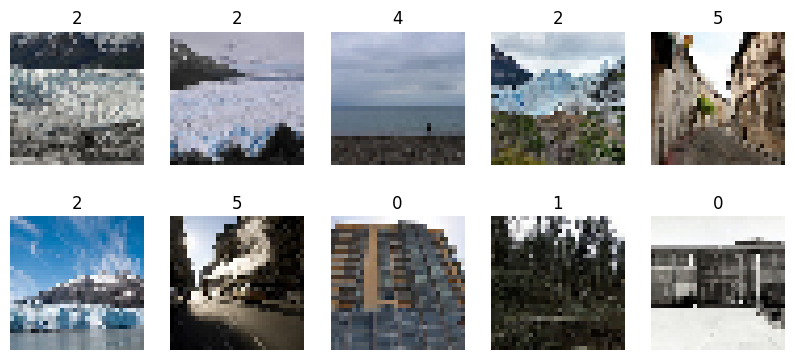

In [28]:
indices = np.random.randint(0,len(X_train),10)
show_images_batch(X_train[indices], y_train_num[indices])

In [27]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [34]:
model = prepare_model()
#model.summary()
history = model.fit(X_train, 
                    y_train_num,
                    batch_size = 96,
                    validation_split=0.2,
                    epochs=100,
                   callbacks= [EarlyStopping(restore_best_weights=True, patience=15)])

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 69s 301ms/step - acc: 0.2261 - loss: 1.8092 - val_acc: 0.1486 - val_loss: 1.7918
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - acc: 0.2946 - loss: 1.6410 - val_acc: 0.1486 - val_loss: 1.7921
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 33s 285ms/step - acc: 0.3481 - loss: 1.5569 - val_acc: 0.1756 - val_loss: 1.7917
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - acc: 0.3959 - loss: 1.4654 - val_acc: 0.1486 - val_loss: 1.7918
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step - acc: 0.4330 - loss: 1.3802 - val_acc: 0.1486 - val_loss: 1.7920
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - acc: 0.4661 - loss: 1.3207 - val_acc: 0.1724 - val_loss: 1.7919
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - acc: 0.5035 - loss: 1.2370 - val_acc: 0.1649 - val_loss: 1.7922
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 371ms/step - acc: 0.5429 - loss: 1.1610 - val_acc: 0.1649 - val_loss: 1.7918
Epoch 9/100
117/117 ━━━━

In [20]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.4181 - loss: 1.7901


[1.7921336889266968, 0.1456666737794876]

In [21]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
              precision    recall  f1-score   support

   buildings       0.15      1.00      0.25       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.00      0.00      0.00       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.15      3000
   macro avg       0.02      0.17      0.04      3000
weighted avg       0.02      0.15      0.04      3000



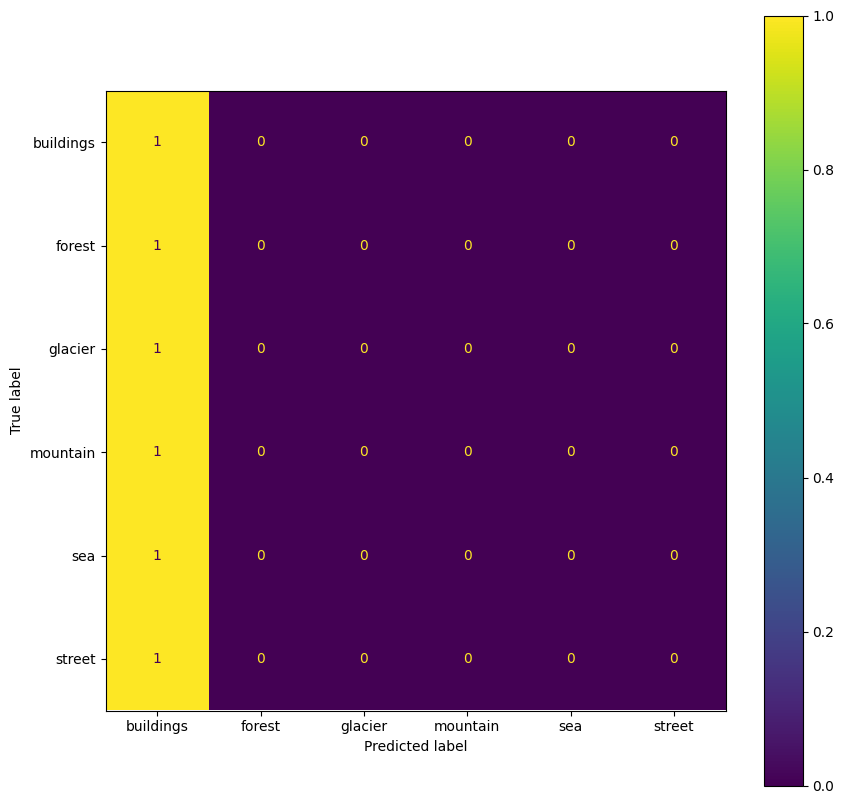

In [22]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

Comparación:
Ha ido muy mal a pesar de haber probado cosas diferentes :(
He probado diferentes:
- números de unidades
- batch sizes
- comprobar que no la he liado con los datos de entrada


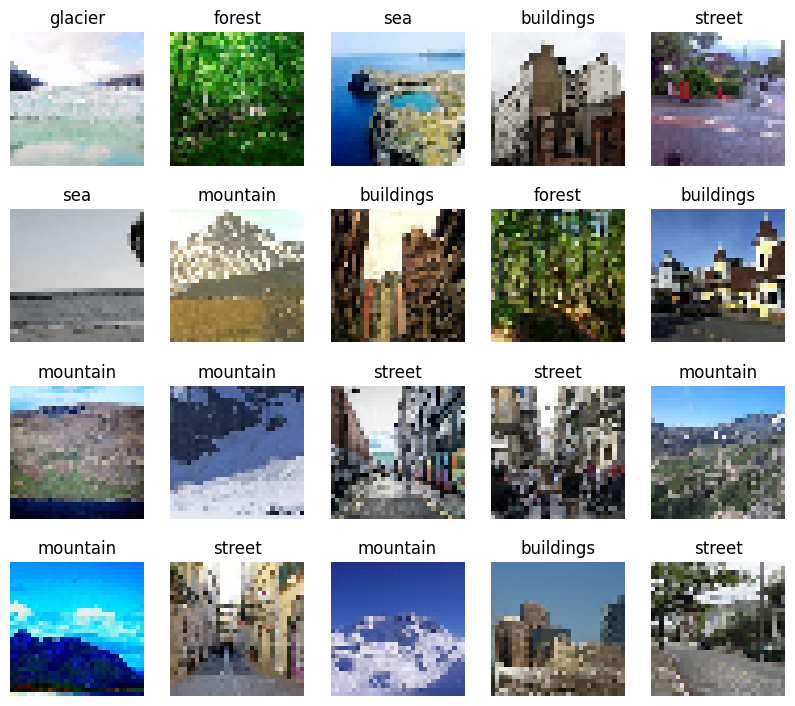

In [23]:
indices = np.random.randint(0,len(X_test),20)
show_images_batch(X_test[indices], names = y_test[indices], n_cols = 5)